In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)
GALARY = '/tigress/jiaxuanl/public_html/galary/'

In [66]:
### UDG ###
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)


fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 32.70887732960614


In [74]:
### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 32.36912377009267


In [6]:
from paper_figure import quenched_frac

% of contaminants in the sample: 20.32 +- 2.04


(<Figure size 496.8x388.8 with 1 Axes>,
 <AxesSubplot:xlabel='$\\log\\ M_\\star\\ [M_\\odot]$', ylabel='Quenched Fraction'>)

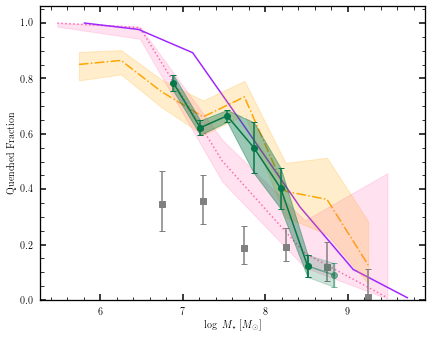

In [7]:
quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=None, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)

In [75]:
udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist2host_arcmin = dist.to(u.arcmin).value

In [76]:
bands = 4

paper_cat = Table([
    Column(name='ID', data=udg_cat['viz-id'], description='Unique LSBG ID'),
    Column(name='ra', data=udg_cat['ra'], description='Right ascension (J2000)'),
    Column(name='dec', data=udg_cat['dec'], description='Declination (J2000)'),
    Column(name='re', data=udg_cat['rhalf_spergel'], description='Circularized effective radius'),
    Column(name='re_err', data=udg_cat['rhalf_spergel_err'], description='Uncertainty of $r_e$'),
    Column(name='mueff_g', data=udg_cat['SB_eff_avg'][:, 0] * u.mag / u.arcsec**2, description='$g$-band average surface brightness within $r_e$ '),
    Column(name='mueff_g_err', data=udg_cat['SB_eff_avg_err'][:, 0] * u.mag / u.arcsec**2, description='Uncertainty of $\overline{\mu}_{\mathrm{eff}}(g)$'),
    Column(name='mag_g', data=udg_cat['mag'][:, 0] * u.mag, description='$g$-band apparent magnitude'),
    Column(name='mag_g_err', data=udg_cat['mag_err'][:, 0] * u.mag, description='Uncertainty of $m_g$'),
    Column(name='g-i', data=udg_cat['g-i'] * u.mag, description='$g-i$ color'),
    Column(name='g-i_err', data=udg_cat['g-i_err'] * u.mag, description='Uncertainty of $g-i$ color'),
    Column(name='g-r', data=udg_cat['g-r'] * u.mag, description='$g-r$ color'),
    Column(name='g-r_err', data=udg_cat['g-r_err'] * u.mag, description='Uncertainty of $g-r$ color'),
    Column(name='nu', data=udg_cat['spergel_nu'], description='Spergel index'),
    Column(name='ell', data=udg_cat['ell_cen'], description='Ellipticity'),
    Column(name='A_g', data=udg_cat['A_g'] * u.mag, description='$g$-band Galactic extinction'),
    Column(name='A_r', data=udg_cat['A_r'] * u.mag, description='$r$-band Galactic extinction'),
    Column(name='A_i', data=udg_cat['A_i'] * u.mag, description='$i$-band Galactic extinction'),
    Column(name='comp', data=udg_cat['completeness'], description='Completeness'),
    Column(name='weight', data=np.loadtxt(f'./{name.upper()}_weights.txt'), description='Importance weight'),
    Column(name='re_phys', data=udg_cat['rhalf_phys'], description='Circularized physical effective radius'),
    Column(name='log_m_star', data=udg_cat['log_m_star'], description='log10 stellar mass'),
    Column(name='host_name', data=udg_cat['host_name'], description='Host galaxy name'),
    Column(name='host_ra', data=udg_cat['host_RA'] * u.deg, description='Host galaxy Right ascension (J2000)'),
    Column(name='host_dec', data=udg_cat['host_DEC'] * u.deg, description='Host galaxy Declination (J2000)'),
    Column(name='host_z', data=udg_cat['host_z'], description='Host galaxy redshift'),
    Column(name='host_log_m_star', data=udg_cat['host_stellar_mass'], description='Host galaxy log10 stellar mass'),
    Column(name='host_r_vir', data=udg_cat['host_r_vir'] * u.kpc, description='Host galaxy virial radius'),
    Column(name='host_g-i', data=udg_cat['host_gi'] * u.mag, description='Host galaxy g-i color'),
    Column(name='sep_to_host', data=dist2host_arcmin * u.arcmin, description='Angular separation between the host and UDG (UPG)'),
           ])

In [77]:
paper_cat.round(4)

In [78]:
# paper_cat.write(f'/tigress/jiaxuanl/public_html/figure/udg_paper/{name}_catalog.txt', 
#                 delimiter='\t', format='ascii', overwrite=True)

In [79]:
# https://github.com/cds-astro/cds.pyreadme/
import cdspyreadme

tablemaker = cdspyreadme.CDSTablesMaker()
tablemaker.addTable(paper_cat, name=f"{name}_cat")
tablemaker.writeCDSTables()

# Customize ReadMe output
tablemaker.title = "Beyond Ultra-Diffuse Galaxies I: Mass-Size Outliers in the Satellites of Milky Way Analogs"
tablemaker.author = 'Jiaxuan Li'
tablemaker.authors = 'Jenny E. Greene, Johnny Greco, Song Huang, Peter Melchior, Rachel Beaton, Kirsten Casey, Shany Danieli, Andy Goulding, Remy Joseph, Erin Kado-Fong, Ji Hoon Kim, Lauren MacArthur'
tablemaker.date = 2022
tablemaker.keywords = 'Low surface brightness galaxies (940), Dwarf galaxies (416), Galaxy properties (615), Galaxy abundances (574)'
tablemaker.abstract = r"Large diffuse galaxies are hard to find, but understanding the environments where they live and their numbers, and ultimately their origins, is of intense interest and important for galaxy formation and evolution. Using the Hyper Suprime-Cam data, we perform a systematic search for low surface-brightness galaxies and present novel and effective methods for detecting and modeling them. As a case study, we build a statistical sample of galaxies that are outliers in the mass-size relation and are satellites of Milky Way analogs in the nearby Universe ($0.01 < z < 0.04$). These ultra-puffy galaxies (UPGs), defined to be $1.5\sigma$ above the average mass-size relation, better represents the tail of satellite size distribution. We find that each MW analog hosts $N_{\rm UPG} = 0.61\pm 0.04$ ultra-puffy galaxies on average, which is comparable to the observed abundance at this halo mass in the Local Volume. We also construct a sample of ultra-diffuse galaxies (UDGs) in MW analogs and find an abundance of $N_{\rm UDG} = 0.76\pm0.04$ per host. We compare with literature results including UDG searches in clusters and massive groups. The UDG abundance scales with the host halo mass following a sublinear power law. We argue that our definition for ultra-puffy galaxies, which is based on the mass-size relation, is more physically-motivated and objective than the common definition of ultra-diffuse galaxies, which depends on a surface brightness cut and thus yields different surface mass density cuts for quenched and star-forming galaxies. "
tablemaker.more_description = "The UDG and UPG catalog contains all objects satisfying the UDG (UPG) definition without any statistical background subtraction. We already applied the measurement bias correction and extinction correction. "
tablemaker.bibcode = ''
tablemaker.acknowledgements = ''
# tablemaker.makeReadMe()

tablemaker.toMRT()

with open(f"/tigress/jiaxuanl/public_html/figure/udg_paper/{name}_cds.dat", "w") as fd:
    tablemaker.makeReadMe(out=fd)
    fd.write('--------------------------------------------------------------------------------')
    fd.write('\n')
    for table in tablemaker._CDSTablesMaker__tables:
        table.makeCDSTable(fd)

In [80]:
from astropy.io import ascii
table = ascii.read(f"/tigress/jiaxuanl/public_html/figure/udg_paper/{name}_cds.dat", 
                   format='cds')

In [81]:
table

ID,ra,dec,re,re_err,mueff_g,mueff_g_err,mag_g,mag_g_err,g-i,g-i_err,g-r,g-r_err,nu,ell,A_g,A_r,A_i,comp,weight,re_phys,log_m_star,host_name,host_ra,host_dec,host_z,host_log_m_star,host_r_vir,host_g-i,sep_to_host
,deg,deg,arcsec,arcsec,mag / arcsec2,mag / arcsec2,mag,mag,mag,mag,mag,mag,,,mag,mag,mag,,,kpc,,,deg,deg,,,kpc,mag,arcmin
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64
64,128.6746,-1.9038,5.5282,0.3,23.8875,0.05,18.1791,0.05,0.6358,0.05,0.1332,0.05,0.168,0.5451,0.0847,0.06,0.0428,0.9075,0.7108,3.3755,8.7027,J083531.40-015402.9,128.8803,-1.9009,0.0295,10.9249,471.5794,1.3539,12.3352
407,3.1769,-0.0282,4.2246,0.3,24.1622,0.05,19.0378,0.05,0.6083,0.05,0.2066,0.05,0.2762,0.1221,0.0802,0.0568,0.0406,0.8894,0.7253,3.412,8.6662,J001233.70-000254.4,3.1405,-0.0485,0.0395,10.8991,449.1192,1.11,2.5014
1072,210.4748,-1.3429,8.6307,0.4192,24.6145,0.0528,17.9388,0.058,0.4804,0.05,0.1357,0.05,0.7585,0.1673,0.13,0.0921,0.0658,0.8575,0.6854,4.4797,8.5514,J140204.79-012128.4,210.52,-1.3579,0.0249,10.8062,382.2638,0.958,2.8572
1670,354.385,-0.4596,2.3168,0.6441,25.2931,0.1718,21.4733,0.1409,0.6882,0.0655,0.176,0.05,0.5196,0.2405,0.0919,0.0651,0.0465,0.874,0.6311,1.7048,7.6297,J233743.26-003104.3,354.4303,-0.5179,0.0358,10.9873,532.7292,1.3259,4.4313
1699,181.9242,1.5087,3.4764,0.7347,25.9056,0.1679,21.2045,0.1634,0.679,0.0742,0.2435,0.055,1.2343,0.2841,0.0742,0.0526,0.0375,0.8539,0.646,1.4618,7.2784,J120738.07+013427.2,181.9086,1.5742,0.0201,10.3072,220.5616,1.2064,4.0416
1984,189.9153,0.8239,7.0219,0.4134,25.1357,0.0606,18.908,0.0713,0.7529,0.05,0.2349,0.05,-0.148,0.3136,0.0447,0.0317,0.0226,0.8735,0.7295,2.5023,8.0883,J123911.40+004307.9,189.7978,0.7174,0.017,10.2945,218.8789,0.6792,9.5157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88167,128.0465,-1.1719,2.9889,0.3277,24.7592,0.0965,20.3862,0.0674,0.3379,0.05,0.0284,0.05,0.5793,0.4482,0.0917,0.0649,0.0464,0.928,0.563,1.9088,7.5751,J083132.90-011152.0,127.887,-1.1978,0.0309,10.8066,382.5583,1.0853,9.6911


### Random catalog

In [8]:
fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
# density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg
# print(density_bkg)

In [9]:
fake_udg_cat

viz-id,ra,dec,image_flag,psf_flag,radius,flux,mag,mag_err,g-i,g-i_err,g-r,g-r_err,SB_eff_avg,SB_eff_avg_err,rhalf_spergel,rhalf_spergel_err,rhalf_phys,rhalf_phys_err,abs_mag,abs_mag_err,log_ML_g,log_ML_g_err,log_m_star,log_m_star_err,completeness,tract,patch,synth_id,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,A_g,A_r,A_i,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_gi,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC,SB_eff_circ,SB_0,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circularized,spergel_nu,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,S,A_outer,A_shape,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,flag_sersic
,deg,deg,,,arcmin,,,,,,,,,,arcsec,arcsec,kpc,kpc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,bool[5],bool[5],float64,float64[4],float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64,int64,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float64[4],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
85336,349.1739714,0.9834224,True .. True,True .. True,0.7,148.00871443628438 .. 255.66958355822334,21.3984344745383 .. 20.98213819567736,0.1278586952918158 .. 0.12113089533003793,0.4162962788609388,0.059415531964727764,0.07372801964690301,0.05,25.069281449111944 .. 24.652985170251007,0.16023930730775876 .. 0.18641468688256538,2.1631142619517796,0.5829809959617507,1.3190648396046165,0.35550120835362903,-14.225723213319613 .. -14.64201949218055,0.1278586952918158 .. 0.12113089533003793,-0.4836351097318783,0.0770619449582519,7.218654175595967,0.09248891130630044,0.9068656790878502,9705,"6,5",-1,21.5691,21.1935,21.056,2.848104,3.088344,0.12248626102628965,0.08679740922091851,0.06194402622269829,2,0,0,0,0,0,2,2,0,J083522.80-013943.0,0.029460426419973373,125.78018365777451,10.215250342616663,11.713136672973633,207.97044865693607,0.09473534448459521,0.13665693144827817,1.2189626693725586,--,--,--,--,128.84487465812205,-1.6619141178979397,26.098571687640813 .. 25.505092243706947,24.21984657095272 .. 23.626367127018852,0.3990644041614908,0.3990641150476947,-1.1986670486417612,-1.198666647282074,2.202642175565362,0.164508137080995,6.209196830576205,12.885683762588148,23.16984708464254,0.499658139566854,-1.838323975095002,-0.2127336944032363,-0.08786547436701986,2.859438702147754,0.004352807950118222,0.0031392084035252827,0.003634810596734034,0.04295422355361637,1.2759496158646055,16.677221032109003,0.41763110023295763,1.942896384171148,0.0
74086,353.2399377,0.6795777,True .. True,True .. True,0.7,160.23517158969995 .. 387.15710509187943,21.277196185852652 .. 20.529733799101617,0.16575134471580757 .. 0.1635792944556178,0.7474623867510355,0.07589223922473895,0.22188943263798505,0.05589365757605351,25.829888384653586 .. 25.08242599790255,0.17573912093874353 .. 0.18991410545824902,3.246747431098152,0.7458537670680891,1.5588262087237497,0.35809881262856014,-13.800498325250842 .. -14.547960712001878,0.16575134471580757 .. 0.1635792944556178,-0.13745471544206078,0.09843223427448641,7.3947446146582765,0.11867883580606584,0.8657256354590755,9708,"8,4",-1,21.6306,21.1548,20.816,3.44736,3.542784,0.10419316660934214,0.07383437819424771,0.05269280154849192,1,0,0,0,0,0,1,1,0,J123901.12+002155.9,0.02301519364118576,99.03181407420172,10.971159308681116,12.892919540405273,516.321773186427,0.2987227616596775,0.17356778883222795,1.2425168603658676,29.

### What's the bias corrections? 

In [82]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
from sample_cuts import post_process_cat_new_rbf
cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

In [83]:
cuts_cat['re_bias'] = cuts_cat['rhalf_spergel'] - input_cuts_cat['rhalf_spergel'] * 0.168
cuts_cat['mag_g_bias'] = cuts_cat['mag'][:, 0] - input_cuts_cat['mag'][:, 0]
cuts_cat['SB_g_bias'] = cuts_cat['SB_eff_avg'][:, 0] - input_cuts_cat['SB_eff_avg'][:, 0]
cuts_cat['g-i_bias'] = cuts_cat['g-i'] - (input_cuts_cat['mag'][:, 0] - input_cuts_cat['mag'][:, 2])
cuts_cat['g-r_bias'] = cuts_cat['g-r'] - (input_cuts_cat['mag'][:, 0] - input_cuts_cat['mag'][:, 1])

In [84]:
### UDG ###
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)


fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 32.70887732960614


In [89]:
### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 32.36912377009267


In [90]:
udg_bias = cuts_cat[
    np.in1d(cuts_cat['viz-id'], udg_cat['viz-id'])]['viz-id', 'ra', 'dec', 're_bias', 'mag_g_bias', 'SB_g_bias', 'g-i_bias', 'g-r_bias']

In [91]:
bands = 4

paper_cat = Table([
    Column(name='ID', data=udg_bias['viz-id'], description='Unique LSBG ID'),
    Column(name='ra', data=udg_bias['ra'], description='Right ascension (J2000)'),
    Column(name='dec', data=udg_bias['dec'], description='Declination (J2000)'),
    Column(name='re_bias', data=udg_bias['re_bias'], description='Bias correction on circularized half-light radius'),
    Column(name='mag_g_bias', data=udg_bias['mag_g_bias'], description='Bias correction on g-band magnitude'),
    Column(name='SB_g_bias', data=udg_bias['SB_g_bias'], description='Bias correction on g-band average surface brightness'),
    Column(name='g-i_bias', data=udg_bias['g-i_bias'], description='Bias correction on g-i color'),
    Column(name='g-r_bias', data=udg_bias['g-r_bias'], description='Bias correction on g-r color'),
           ])
paper_cat.round(4)

In [92]:
paper_cat.write(f'/tigress/jiaxuanl/public_html/figure/udg_paper/{name}_bias.fits')

In [93]:
5 * 3 * 2

30

In [ ]:
55*35*24